<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:170%;
            text-align:center;
            border-radius:15px;
            background-color:#419E61;
            overflow:hidden;
            font-weight:700;">
    Green Defend
    <div style="font-size:70%; font-weight:500; margin-top:5px;">
        Intelligent Plant Disease Detection and Agriculyure Support System
    </div>
</div>

<style>
    .jp-InputArea-editor {
        display: none;
    }
</style>


<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About NoteBook
</div>

The goal of this project is to identify 38 different plant diseases from RGB images of crop leaves. By leveraging deep learning techniques, this model helps in detecting and categorizing diseases, aiding farmers and agricultural experts.


<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About DataSet
</div>


> * This dataset is recreated using offline augmentation from the original dataset.
> * This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. 
> * The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structurs
> *  A new directory containing 33 test images is created later for prediction purpose.

## Import libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [3]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

test_dir  ="/kaggle/input/new-plant-diseases-dataset/test/test"

In [4]:
image_shape = (224,224)
batch_size = 64

In [5]:
# apply scaling only becouse data already augmented

train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

## Load training, Validation and Testing data

### Training data


In [6]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

Found 56251 images belonging to 38 classes.


### Validation data (20% of training data)


In [7]:
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 14044 images belonging to 38 classes.


### Test data (consider validation data as test data)


In [8]:
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test datata

### What are 38 classes are?

In [9]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [11]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [12]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Bacterial_spot                                      1702
Apple___Black_rot                                            1987
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___Bacterial_spot                                       1838
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Grape___Black_rot                                            1888
Potato___Early_blight                                        1939
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Common_rust_                                  1907
Grape___Esca_(Black_Measles)                                 1920
Raspberry___healthy                                          1781
Tomato___Leaf_Mold                                           1882
Tomato___Spider_mites Two-spotted_spider_mite                1741
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___healthy                                       1859

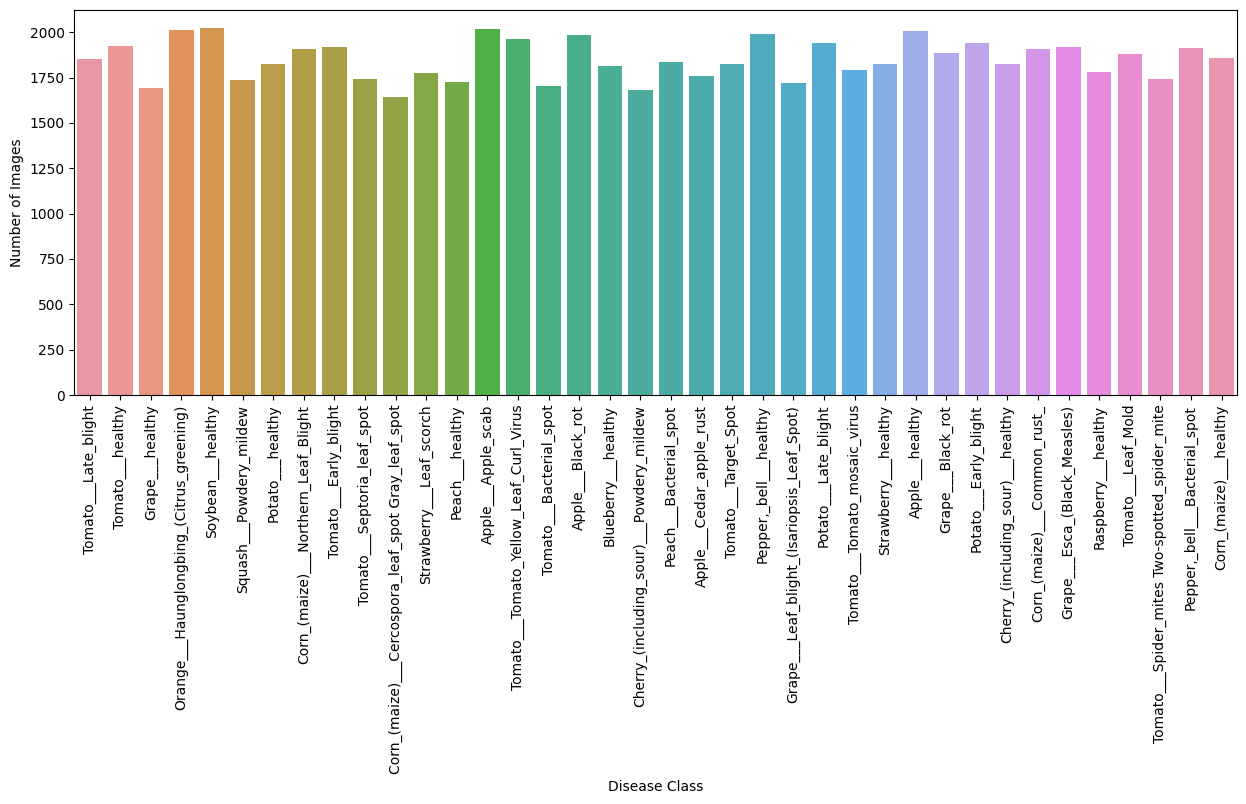

In [13]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

#### As we notice that classes are somewhat balanced

#### Display random samples from data

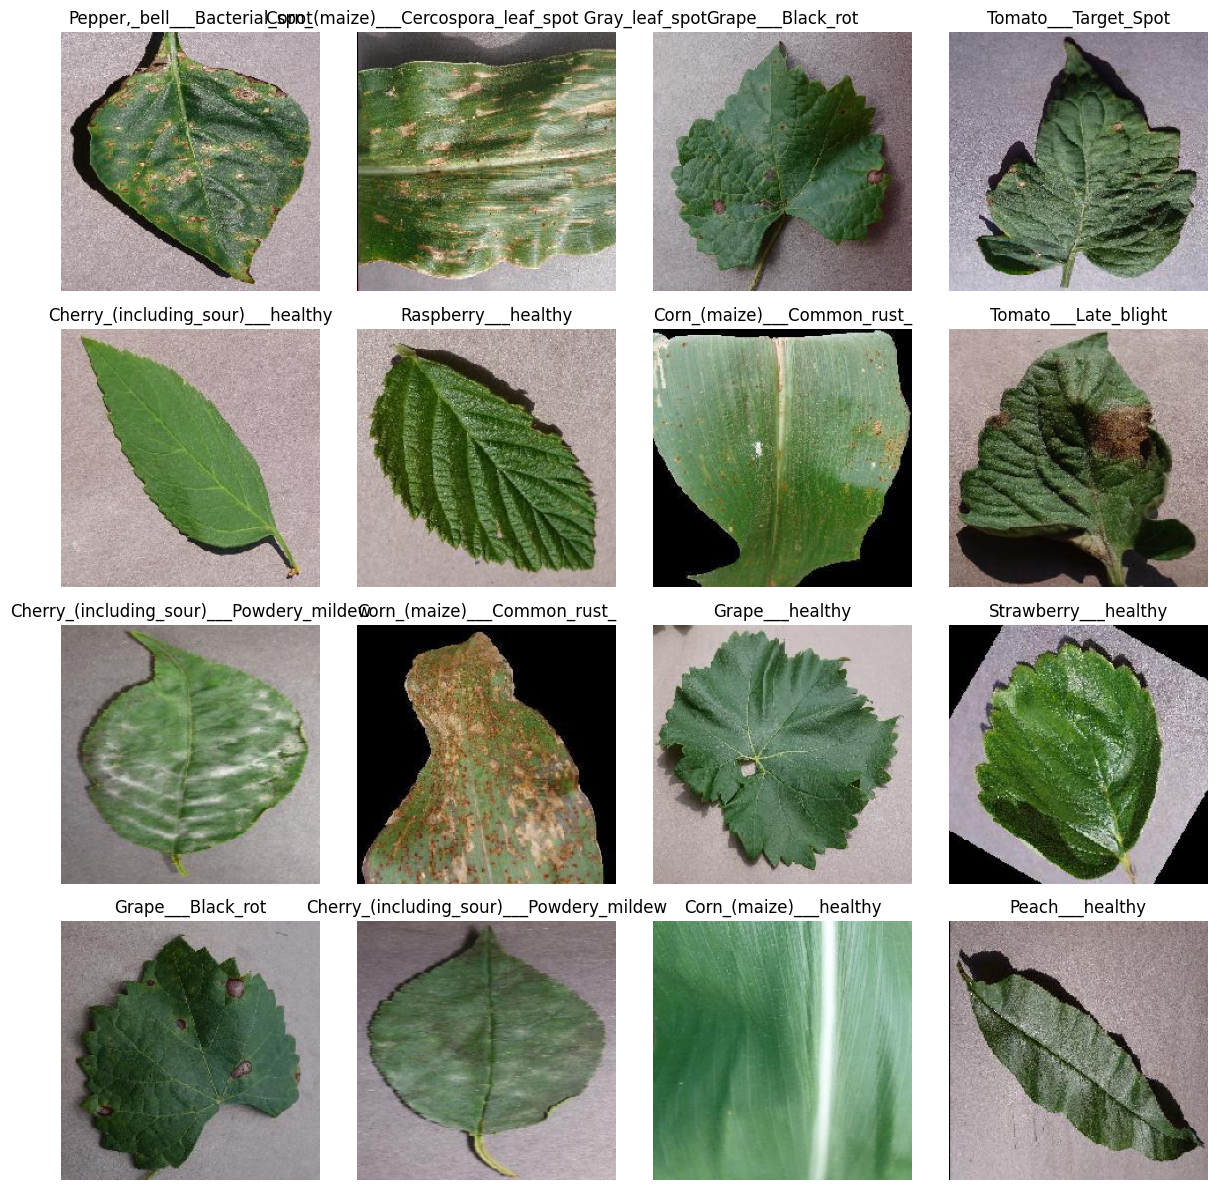

In [14]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()

## CNN Model

In [15]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'elu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

## Train the model


In [16]:
model_checkpoint = ModelCheckpoint('/kaggle/working/green_defend_cnn.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

In [17]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=30,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/30


I0000 00:00:1732828345.887842     123 service.cc:145] XLA service 0x7e292400a390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732828345.887927     123 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732828345.887933     123 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732828371.128041     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.3403 - loss: 2.3425
Epoch 1: val_accuracy improved from -inf to 0.61492, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 480s 511ms/step - accuracy: 0.3405 - loss: 2.3418 - val_accuracy: 0.6149 - val_loss: 1.2570
Epoch 2/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.7322 - loss: 0.8778
Epoch 2: val_accuracy improved from 0.61492 to 0.79614, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 271s 307ms/step - accuracy: 0.7323 - loss: 0.8777 - val_accuracy: 0.7961 - val_loss: 0.6494
Epoch 3/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8374 - loss: 0.5171
Epoch 3: val_accuracy improved from 0.79614 to 0.86257, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 271s 307ms/step - accuracy: 0.8375 - loss: 0.5170 - val_accuracy: 0.8626 - val_loss: 0.4261
Epoch 4/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step 

***Function will be used***
##### Learning curve function
> * learning curve
> * loss curve

In [18]:
def plot_learning_curves(history, save_path=None, color_scheme=('blue', 'orange')):
    plt.figure(figsize=(14, 5))

    # Automatically determine the best epoch based on validation accuracy
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color=color_scheme[0], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color=color_scheme[1], linestyle='--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim(0, best_epoch)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color=color_scheme[0], label='Training Loss')
    plt.plot(history.history['val_loss'], color=color_scheme[1], linestyle='--', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0, best_epoch)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f'Plot saved as {save_path}')

    plt.show()

### Display accuracy and loss curves for model history 

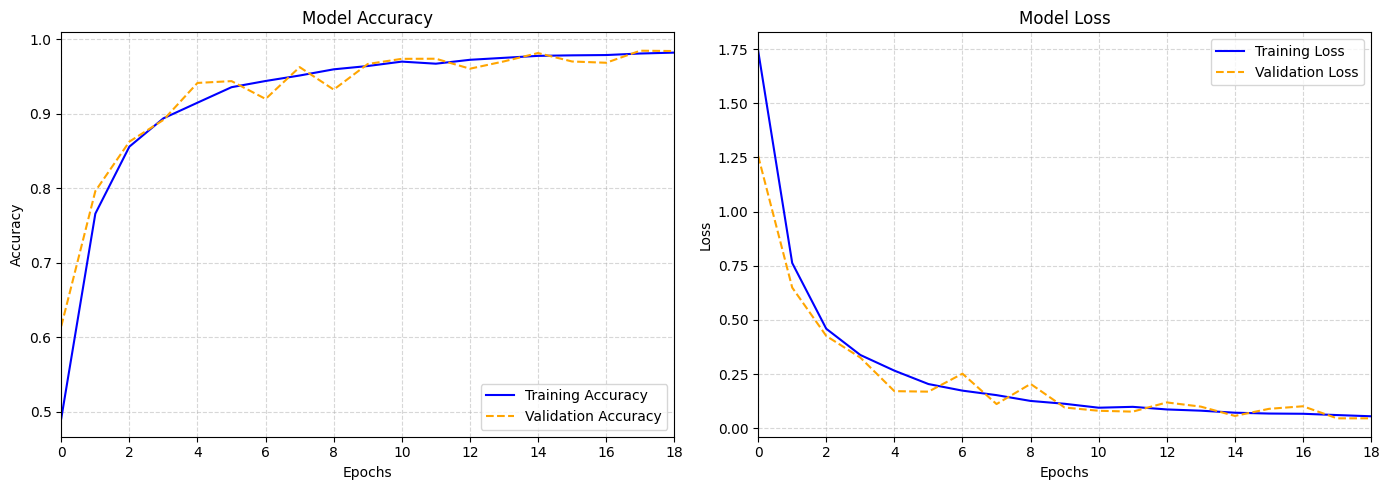

In [19]:
plot_learning_curves(history)

In [20]:
# save model to use later
model.save('/kaggle/working/green_defend_cnn.keras')

In [21]:
# showe accuracy on test data (model evaluation)
best_model = load_model('/kaggle/working/green_defend_cnn.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 130s 470ms/step - accuracy: 0.9893 - loss: 0.0341
Test Loss: 0.0397
Test Accuracy: 0.9873


#### Prediction function
> Compare Truth label (name of image ) with predicted label

In [22]:
def predict_labels_and_display(model_path, test_dir=test_dir, image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### show random sample of prediction of model on test data

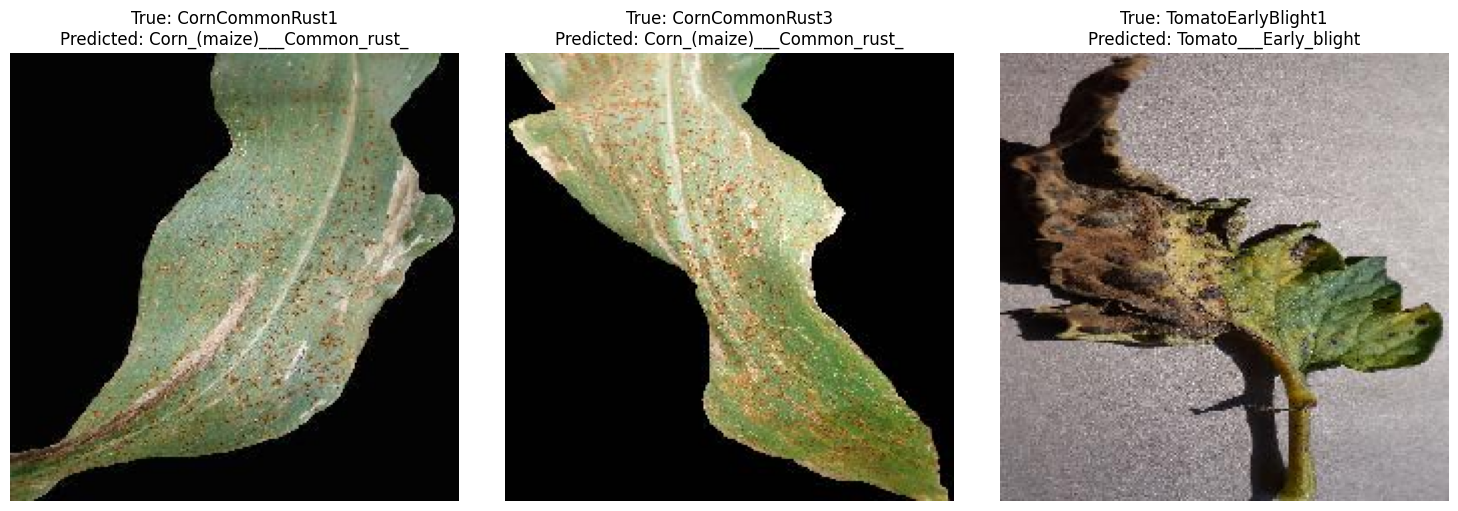

In [23]:
predict_labels_and_display('/kaggle/working/green_defend_cnn.keras')

### Confusion Matrix

275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step


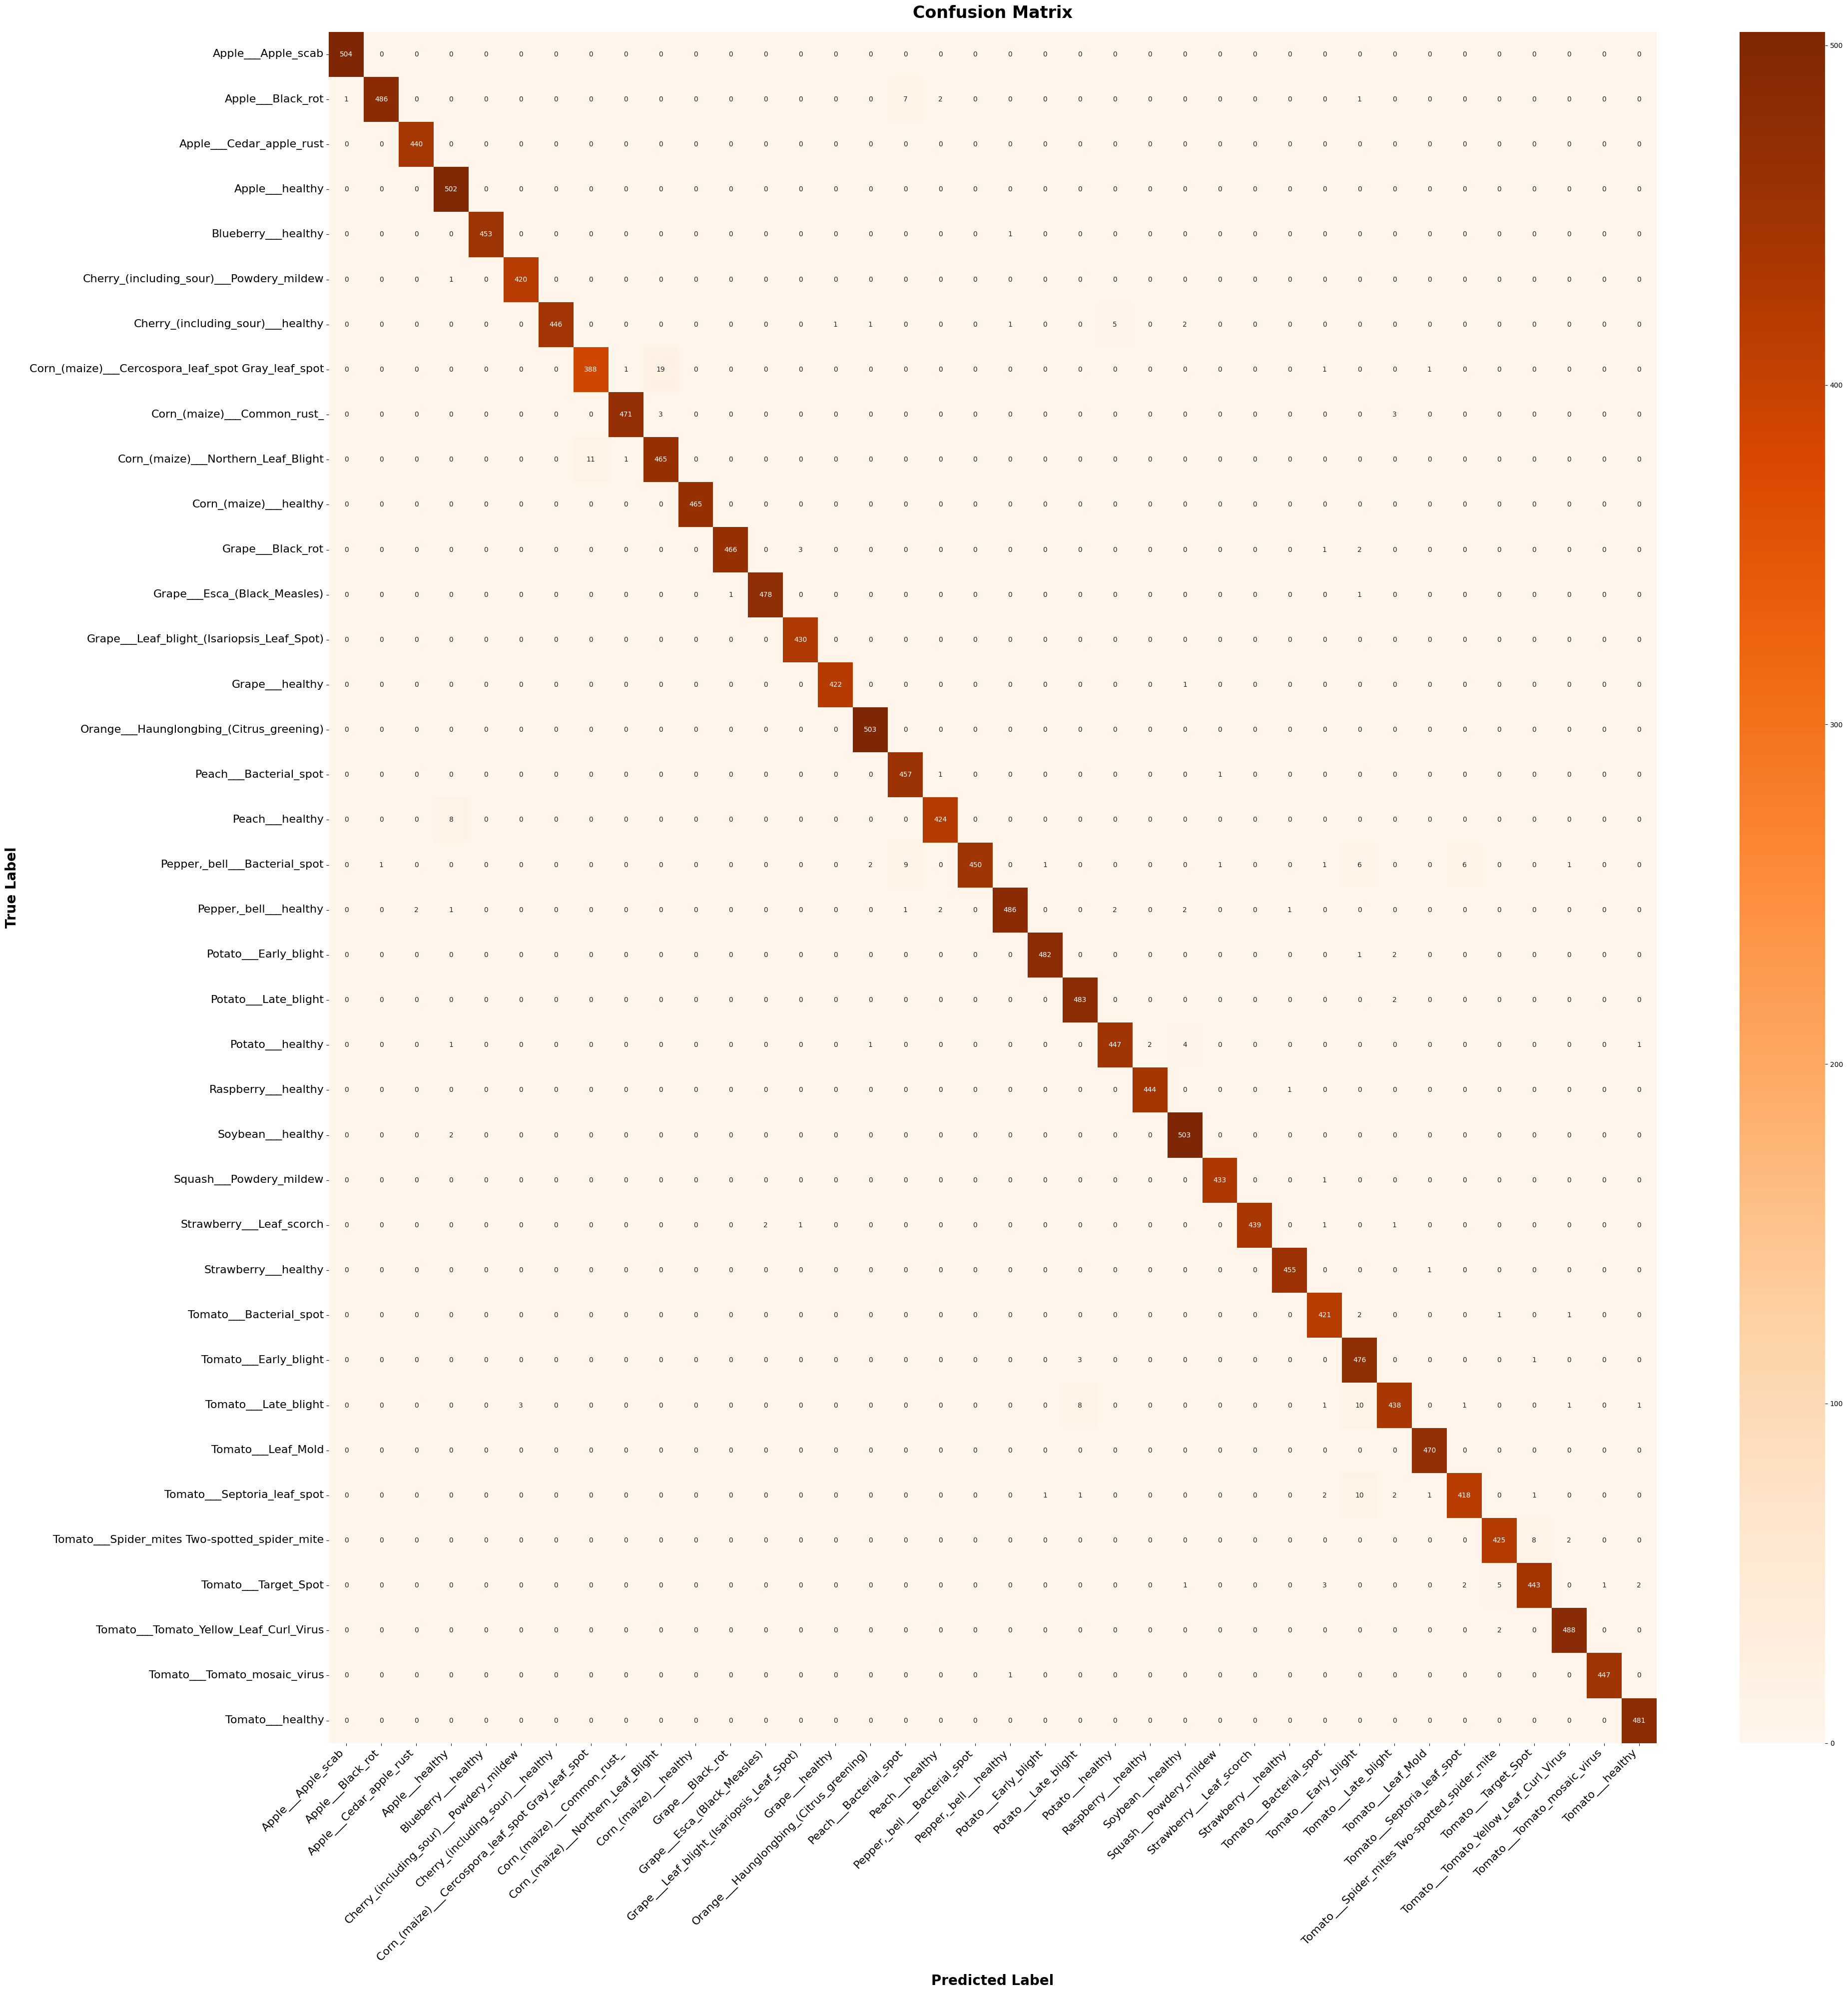

In [24]:
# Generate predictions and true labels
predictions = model.predict(test_data)  # Predict class probabilities for the test dataset
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Retrieve true labels and class names
true_classes = test_data.classes  # Ground truth labels for the test dataset
class_labels = list(test_data.class_indices.keys())  # Class names (label-to-index mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(40, 40))  # Large figure size for high-resolution visualization
sns.heatmap(
    conf_matrix,
    annot=True,            # Display numerical values in the heatmap cells
    fmt='d',               # Format annotations as integers
    cmap='Oranges',        # Color palette for heatmap
    xticklabels=class_labels, 
    yticklabels=class_labels
)

# Add axis labels and title with improved styling
plt.xlabel('Predicted Label', fontsize=20, weight='bold', labelpad=15)  # X-axis label with padding
plt.ylabel('True Label', fontsize=20, weight='bold', labelpad=15)      # Y-axis label with padding
plt.title('Confusion Matrix', fontsize=24, weight='bold', pad=20)     # Heatmap title with padding

# Improve tick labels for readability
plt.xticks(fontsize=16, rotation=45, ha='right')  # Rotate x-axis tick labels
plt.yticks(fontsize=16)                          # Adjust font size for y-axis ticks

# Display the heatmap
plt.tight_layout()  # Optimize layout to prevent clipping of labels
plt.show()


## Evaluate model performance

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

def evaluate_model(model_path, test_data, model_name):
    # load model
    model = tf.keras.models.load_model(model_path)

    # predict
    y_pred = model.predict(test_data)
    y_pred_classes = y_pred.argmax(axis=1)

    # get true classes
    y_true = test_data.classes

    class_labels = list(test_data.class_indices.keys())

    accuracy = accuracy_score(y_true, y_pred_classes)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    df_report = pd.DataFrame(report).transpose()

    df_report.loc['accuracy'] = [accuracy, None, None, None]

    df_report['model'] = model_name

    return df_report

cnn_model_path = 'green_defend_cnn.keras'

cnn_report = evaluate_model(cnn_model_path, test_data, 'CNN')

all_reports = pd.concat([cnn_report])

all_reports = all_reports.reset_index().rename(columns={'index': 'metric'})

all_reports

275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 161ms/step


metric  precision    recall  \
0                                  Apple___Apple_scab   0.998020  1.000000   
1                                   Apple___Black_rot   0.997947  0.977867   
2                            Apple___Cedar_apple_rust   0.995475  1.000000   
3                                     Apple___healthy   0.974757  1.000000   
4                                 Blueberry___healthy   1.000000  0.997797   
5            Cherry_(including_sour)___Powdery_mildew   0.992908  0.997625   
6                   Cherry_(including_sour)___healthy   1.000000  0.978070   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   0.972431  0.946341   
8                         Corn_(maize)___Common_rust_   0.995772  0.987421   
9                 Corn_(maize)___Northern_Leaf_Blight   0.954825  0.974843   
10                             Corn_(maize)___healthy   1.000000  1.000000   
11                                  Grape___Black_rot   0.997859  0.987288   
12                       Grape___Esca_(Black_Measles)   0.995833  0.995833   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   0.990783  1.000000   
14                                    Grape___healthy   0.997636  0.997636   
15           Orange___Haunglongbing_(Citrus_greening)   0.992110  1.000000   
16                             Peach___Bacterial_spot   0.964135  0.995643   
17                                    Peach___healthy   0.988345  0.981481   
18                      Pepper,_bell___Bacterial_spot   1.000000  0.941423   
19                             Pepper,_bell___healthy   0.993865  0.977867   
20                              Potato___Early_blight   0.995868  0.993814   
21                               Potato___Late_blight   0.975758  0.995876   
22                                   Potato___healthy   0.984581  0.980263   
23                                Raspberry___healthy   0.995516  0.997753   
24                                  Soybean___healthy   0.980507  0.996040   
25                            Squash___Powdery_mildew   0.995402  0.997696   
26                           Strawberry___Leaf_scorch   1.000000  0.988739   
27                               Strawberry___healthy   0.995624  0.997807   
28                            Tomato___Bacterial_spot   0.974537  0.990588   
29                              Tomato___Early_blight   0.935167  0.991667   
30                               Tomato___Late_blight   0.977679  0.946004   
31                                 Tomato___Leaf_Mold   0.993658  1.000000   
32                        Tomato___Septoria_leaf_spot   0.978923  0.958716   
33      Tomato___Spider_mites Two-spotted_spider_mite   0.981524  0.977011   
34                               Tomato___Target_Spot   0.977925  0.969365   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   0.989858  0.995918   
36                       Tomato___Tomato_mosaic_virus   0.997768  0.997768   
37                                   Tomato___healthy   0.991753  1.000000   
38                                           accuracy   0.987309       NaN   
39                                          macro avg   0.987493  0.987162   
40                                       weighted avg   0.987471  0.987309   

    f1-score  support model  
0   0.999009    504.0   CNN  
1   0.987805    497.0   CNN  
2   0.997732    440.0   CNN  
3   0.987217    502.0   CNN  
4   0.998897    454.0   CNN  
5   0.995261    421.0   CNN  
6   0.988914    456.0   CNN  
7   0.959209    410.0   CNN  
8   0.991579    477.0   CNN  
9   0.964730    477.0   CNN  
10  1.000000    465.0   CNN  
11  0.992545    472.0   CNN  
12  0.995833    480.0   CNN  
13  0.995370    430.0   CNN  
14  0.997636    423.0   CNN  
15  0.996040    503.0   CNN  
16  0.979636    459.0   CNN  
17  0.984901    432.0   CNN  
18  0.969828    478.0   CNN  
19  0.985801    497.0   CNN  
20  0.994840    485.0   CNN  
21  0.985714    485.0   CNN  
22  0.982418    456.0   CNN  
23  0.996633    445.0   CNN  
24  0.988212    505.

In [26]:
final_report =all_reports[all_reports['metric'] == 'macro avg']
final_report

metric  precision    recall  f1-score  support model
39  macro avg   0.987493  0.987162  0.987236  17572.0   CNN

## Convert Model to TFLite file

**It will be better if you do this step in colab platform**

In [27]:
# import os
# print(os.listdir("/kaggle/working"))

In [28]:
# import tensorflow as tf

# # Load the model
# model = tf.keras.models.load_model('green_defend_cnn.keras')

# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model
# with open('green_defend_cnn.tflite', 'wb') as f:
#     f.write(tflite_model)